## ZEE Recommender System

Problem statement : 

Build a recommender system that's going to recommend movies to a user based on ratings given by a user and other users similar to them in order to improve user experience.

In [1]:
# importing the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors 
import warnings 
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# reading the data 

movies = pd.read_fwf('zee-movies.dat',encoding='ISO-8859-1')
users = pd.read_fwf('zee-users.dat',encoding='ISO-8859-1')
reviews = pd.read_fwf('zee-ratings.dat',encoding='ISO-8859-1')

In [4]:
movies.head(4)

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN


In [5]:
# drop unnamed columns
movies.drop(['Unnamed: 1','Unnamed: 2'],axis=1,inplace=True)
movies.head(4)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama


In [6]:
# split the columns and expand into new columns
movies = movies['Movie ID::Title::Genres'].str.split('::',expand=True)

In [7]:
movies.columns = ['movie_id','title','genres']

In [8]:
movies.head(4)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama


In [9]:
# splitting the reviews 
reviews = reviews['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True)
reviews.columns = ['user_id','movie_id','rating','timestamp']
reviews.head(4)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275


In [10]:
# split users and expand into new columns
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::',expand=True)
users.columns = ['user_id','gender','age','occupation','zip_code']
users.head(4)

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   object
 1   gender      6040 non-null   object
 2   age         6040 non-null   object
 3   occupation  6040 non-null   object
 4   zip_code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [12]:
users["age"].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [13]:
users.replace({"age" : {"1":"Under 18","18":"18-24",
                        "25":"25-34","35":"35-44",
                        "45":"45-49","50":"50-55","56":"56 Above"}} , inplace = True)



- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [14]:
users.replace({"occupation": {
    "0":"other","1":"academic/educator","2":"artist","3":"clerical/admin",
    "4":"college/grad student","5":"customer service","6":"doctor/health care",
    "7":"executive/managerial","8":"farmer","9":"homemaker","10":"K-12 student",
    "11":"lawyer","12":"programmer","13":"retired","14":"sales/marketing",
    "15":"scientist","16":"self-employed","17":"technician/engineer",
    "18":"tradesman/craftsman","19":"unemployed","20":"writer"}},inplace=True)


## Data pre-processing

In [15]:
print(users.shape , movies.shape , reviews.shape)

(6040, 5) (3883, 3) (1000209, 4)


In [16]:
movies.columns

Index(['movie_id', 'title', 'genres'], dtype='object')

In [17]:
# we can merge movies and reviews
reviews.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp'], dtype='object')

In [18]:
movies.head(3)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [19]:
# extract year from title
movies['year'] = movies['title'].str.extract('.*\((.*)\).*')
movies.head(3)

,movie_id,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


In [20]:
# replace year with empty string and then strip it
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '') 
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [21]:
# check if genres contain "ro"
movies[movies['genres'].str.contains("Ro",na=False)].sample(15)

,movie_id,title,genres,year
1639,1685,"I Love You, I Love You Not",Romance,1996
614,618,Two Much,Comedy|Romance,1996
1318,1339,Bram Stoker's Dracula,Horror|Romance,1992
3156,3225,Down to You,Comedy|Romance,2000
2528,2597,Lost & Found,Comedy|Romance,1999
1294,1314,Breathing Room,Romance,1996
457,461,Go Fish,Drama|Romance,1994
742,752,Vermont Is For Lovers,Comedy|Romance,1992
2872,2941,South Pacific,Musical|Romance|War,1958
1976,2045,"Far Off Place, A",Adventure|Children's|Drama|Romance,1993


In [22]:
# movies['genres'].value_counts()[movies['genres'].value_counts() == 1]

There are lot of values in  genres column with incomplete text , let's replace them  with original genre

In [23]:
df_mov = movies.copy() 
df_mov.dropna(inplace=True) 

In [24]:
df_mov['genres'] = df_mov['genres'].str.split('|')

In [25]:
df_mov = df_mov.explode('genres')


In [26]:
df_mov["genres"].value_counts()

Drama       1576
Comedy      1184
Action       500
Thriller     484
Romance      453
            ... 
Childr         1
Music          1
Wester         1
Chil           1
Horr           1
Name: genres, Length: 63, dtype: int64

- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

Manual pre-processing is needed for genre column

In [27]:
# check for romance - ro , romance , roman etc 
df_mov[df_mov["genres"].str.contains("Ro",na=False)]

,movie_id,title,genres,year
2,3,Grumpier Old Men,Romance,1995
6,7,Sabrina,Romance,1995
10,11,"American President, The",Romance,1995
14,15,Cutthroat Island,Romance,1995
16,17,Sense and Sensibility,Romance,1995
...,...,...,...,...
3785,3855,"Affair of Love, An (Une Liaison Pornographique)",Rom,1999
3804,3874,"Couch in New York, A",Romance,1996
3815,3885,Love & Sex,Romance,2000
3818,3888,Skipped Parts,Romance,2000


In [28]:
df_mov[df_mov["genres"].str.contains("Ro",na=False)]["genres"].value_counts().index
#romance
df_mov['genres'] = df_mov['genres'].replace(['Rom', 'Roman', 'Roma', 'Ro','R'], 'romance')

df_mov[df_mov["genres"].str.contains("Ch",na=False)]["genres"].value_counts().index
#  children
df_mov["genres"] = df_mov["genres"].replace(["Children's", 'Childre', 'Children', 'Chil', 'Childr', 'Children''Chi'], "children")
df_mov[df_mov["genres"].str.contains("Fan",na=False)]["genres"].value_counts().index
# replacing with fantasy
df_mov["genres"] = df_mov["genres"].replace(['Fantas', 'Fantas', 'Fantasy','Fant'], 'fantasy')
df_mov[df_mov["genres"].str.contains("Dr",na=False)]["genres"].value_counts().index
#drama
df_mov["genres"] = df_mov["genres"].replace(['Dram', 'Dram', 'Drama', 'Dr'], 'drama')
# documentary
df_mov[df_mov["genres"].str.contains("Doc",na=False)]["genres"].value_counts().index
df_mov["genres"] = df_mov["genres"].replace(['Documenta', 'Document', 'Docu', 'Documen','Documentary'], 'documentary')
df_mov[df_mov["genres"].str.contains("Ad",na=False)]["genres"].value_counts().index
# replacing with adventure
df_mov["genres"] = df_mov["genres"].replace(['Adv', 'Adventu', 'Adventur', 'Advent','Adventure'], 'adventure')

df_mov[df_mov["genres"].str.contains("An",na=False)]["genres"].value_counts().index
# replacing with animation
df_mov["genres"] = df_mov["genres"].replace(['Animati', 'Animation'], 'animation')
df_mov[df_mov["genres"].str.contains("Co",na=False)]["genres"].value_counts().index

df_mov["genres"] = df_mov["genres"].replace(['Come', 'Comed', 'Com','Comedy'], 'comedy')
df_mov[df_mov["genres"].str.contains("Cr",na=False)]["genres"].value_counts().index
# replacing with crime
df_mov["genres"] = df_mov["genres"].replace(['Cr','Crime','Crim','Crime'], 'crime')

# film noir 
df_mov[df_mov["genres"].str.contains("Fi",na=False)]["genres"].value_counts().index

df_mov["genres"] = df_mov["genres"].replace(['Fi','Film-Noir'], 'film-noir')
# horror
df_mov[df_mov["genres"].str.contains("Ho",na=False)]["genres"].value_counts().index

df_mov["genres"] = df_mov["genres"].replace(['Horror', 'Horro', 'Horr'], 'horror')
df_mov[df_mov["genres"].str.contains("Mu",na=False)]["genres"].value_counts().index
#music
df_mov["genres"] = df_mov["genres"].replace(['Musical', 'Music', 'Mus', 'Musical'], 'musical')

df_mov[df_mov["genres"].str.contains("My",na=False)]["genres"].value_counts().index
#mystery
df_mov["genres"] = df_mov["genres"].replace(['My', 'Myst', 'Myster','Mystery'], 'mystery')

df_mov[df_mov["genres"].str.contains("Sci",na=False)]["genres"].value_counts().index
# sci-fi
df_mov["genres"] = df_mov["genres"].replace(['Sci-Fi', 'Sci-', 'Sci', 'Sci-F'], 'sci-fi')

df_mov[df_mov["genres"].str.contains("Th",na=False)]["genres"].value_counts().index 
# thriller
df_mov["genres"] = df_mov["genres"].replace(['Thriller', 'Thri', 'Th', 'Thrille'], 'thriller')

df_mov[df_mov["genres"].str.contains("Wa",na=False)]["genres"].value_counts().index
# war
df_mov["genres"] = df_mov["genres"].replace(['War', 'Wa'], 'war')

df_mov[df_mov["genres"].str.contains("We",na=False)]["genres"].value_counts().index
# western
df_mov["genres"] = df_mov["genres"].replace(['Western', 'Wester', 'We'], 'western')

df_mov[df_mov["genres"].str.contains("Ac",na=False)]["genres"].value_counts().index
# action
df_mov["genres"] = df_mov["genres"].replace(['Action', 'Ac','Acti'], 'action')

df_mov["genres"] = df_mov["genres"].replace(["Children's", 'Childre', 'Children', 'Chil', 'Childr', 'Children','Chi',"Children'"], "children")
df_mov["genres"] = df_mov["genres"].replace(['Romance','romance'],'romance')

# everything else with na   
df_mov["genres"] = df_mov["genres"].replace(['D', 'S', 'A', 'F',''], 'na')

<AxesSubplot: >

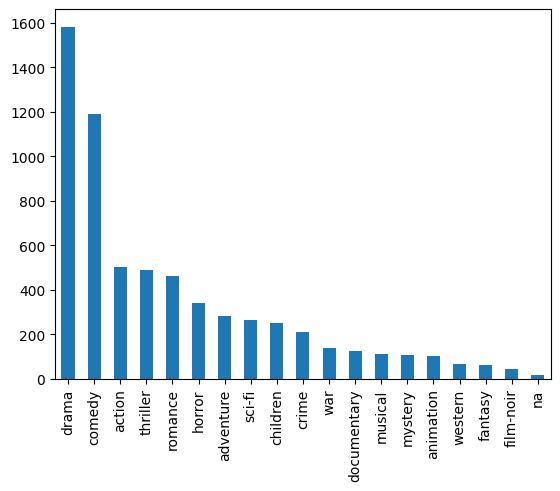

In [29]:
df_mov["genres"].value_counts().plot(kind='bar')

In [30]:
df_mov.head(4)

,movie_id,title,genres,year
0,1,Toy Story,animation,1995
0,1,Toy Story,children,1995
0,1,Toy Story,comedy,1995
1,2,Jumanji,adventure,1995


In [31]:
reviews.head(4)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275


In [32]:
df_1 = pd.merge(df_mov, reviews, on='movie_id') 
df_1.head(4)

,movie_id,title,genres,year,user_id,rating,timestamp
0,1,Toy Story,animation,1995,1,5,978824268
1,1,Toy Story,animation,1995,6,4,978237008
2,1,Toy Story,animation,1995,8,4,978233496
3,1,Toy Story,animation,1995,9,5,978225952


In [33]:
df_1.shape

(2060031, 7)

In [34]:
users.head(4)

,user_id,gender,age,occupation,zip_code
0,1,F,Under 18,K-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460


In [35]:
mix_df = pd.merge(df_1, users, on='user_id',how='inner')

In [36]:
mix_df.head(4)

,movie_id,title,genres,year,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story,animation,1995,1,5,978824268,F,Under 18,K-12 student,48067
1,1,Toy Story,children,1995,1,5,978824268,F,Under 18,K-12 student,48067
2,1,Toy Story,comedy,1995,1,5,978824268,F,Under 18,K-12 student,48067
3,48,Pocahontas,animation,1995,1,5,978824351,F,Under 18,K-12 student,48067


In [37]:
mix_df.isna().sum()

movie_id      0
title         0
genres        0
year          0
user_id       0
rating        0
timestamp     0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

In [38]:
mix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060031 entries, 0 to 2060030
Data columns (total 11 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   movie_id    object
 1   title       object
 2   genres      object
 3   year        object
 4   user_id     object
 5   rating      object
 6   timestamp   object
 7   gender      object
 8   age         object
 9   occupation  object
 10  zip_code    object
dtypes: object(11)
memory usage: 188.6+ MB


In [39]:
mix_df["rating"] = mix_df["rating"].astype('int32')

mix_df["datetime"] = pd.to_datetime(mix_df['timestamp'], unit='s')

In [40]:
mix_df["year"] = mix_df["year"].astype('int32')

<AxesSubplot: >

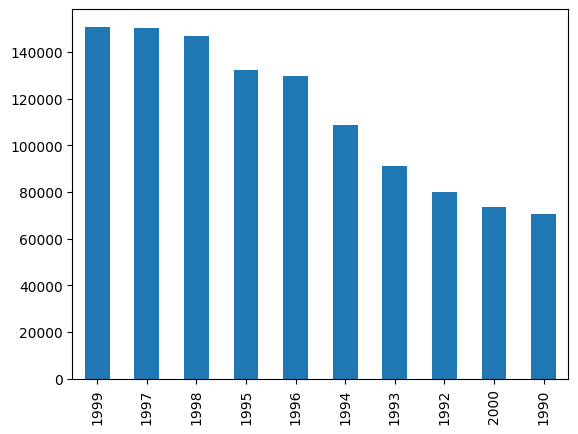

In [41]:
mix_df["year"].value_counts().nlargest(10).plot(kind='bar')

In [42]:
print(mix_df["year"].min(), mix_df["year"].max())

1919 2000


Data contanis movies released from 1919 to 2000

In [43]:
# let's bin the data for every ten years 
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000] 
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'] 
mix_df["release_bins"] = pd.cut(mix_df["year"], bins=bins, labels=labels,include_lowest=True)

In [44]:
mix_df.head(3)

,movie_id,title,genres,year,user_id,rating,timestamp,gender,age,occupation,zip_code,datetime,release_bins
0,1,Toy Story,animation,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
1,1,Toy Story,children,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
2,1,Toy Story,comedy,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s


In [45]:
mix_df[mix_df["year"] == 1919].shape

(48, 13)

In [46]:
mix_df.isna().sum()

movie_id        0
title           0
genres          0
year            0
user_id         0
rating          0
timestamp       0
gender          0
age             0
occupation      0
zip_code        0
datetime        0
release_bins    0
dtype: int64

Analysis of features :

In [47]:
mix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2060031 entries, 0 to 2060030
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   movie_id      object        
 1   title         object        
 2   genres        object        
 3   year          int32         
 4   user_id       object        
 5   rating        int32         
 6   timestamp     object        
 7   gender        object        
 8   age           object        
 9   occupation    object        
 10  zip_code      object        
 11  datetime      datetime64[ns]
 12  release_bins  category      
dtypes: category(1), datetime64[ns](1), int32(2), object(9)
memory usage: 190.6+ MB


In [48]:
mix_df["user_id"].nunique()

6040

In [49]:
user_avg_rating = mix_df[["user_id","rating"]].groupby("user_id").mean()

Text(0.5, 1.0, 'User Average Rating Distribution')

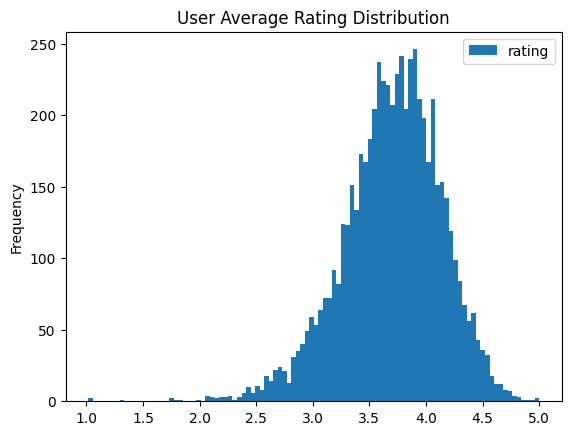

In [50]:
user_avg_rating.plot(kind='hist',bins=100)
plt.title("User Average Rating Distribution")

In [51]:
mix_df[["gender","rating"]].groupby("gender").mean()

,rating
gender,
F,3.617644
M,3.562274


In [52]:
mix_df.duplicated().sum() # no duplicates

0

In [53]:
mix_df["age"].value_counts()

25-34       815051
35-44       409326
18-24       383715
45-49       170335
50-55       146883
56 Above     77252
Under 18     57469
Name: age, dtype: int64

<AxesSubplot: >

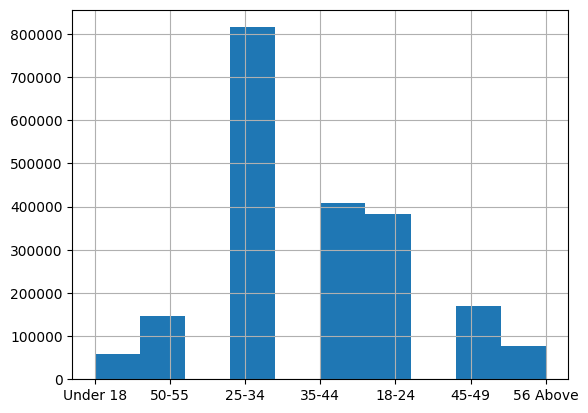

In [54]:
mix_df["age"].hist()

In [55]:
# average rating by age 
mix_df[["age","rating"]].groupby("age").mean()

,rating
age,
18-24,3.500369
25-34,3.538820
35-44,3.617596
45-49,3.637268
50-55,3.712615
56 Above,3.754311
Under 18,3.528198


<AxesSubplot: ylabel='gender'>

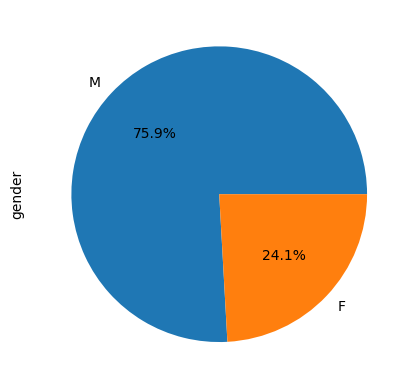

In [56]:
# gender distribution
mix_df["gender"].value_counts().plot(kind='pie', autopct='%1.1f%%')

<AxesSubplot: >

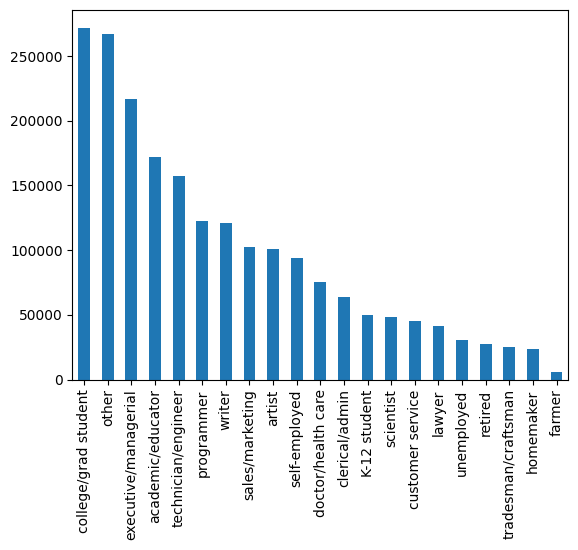

In [57]:
# occupation 
mix_df["occupation"].value_counts().plot(kind='bar')

<AxesSubplot: >

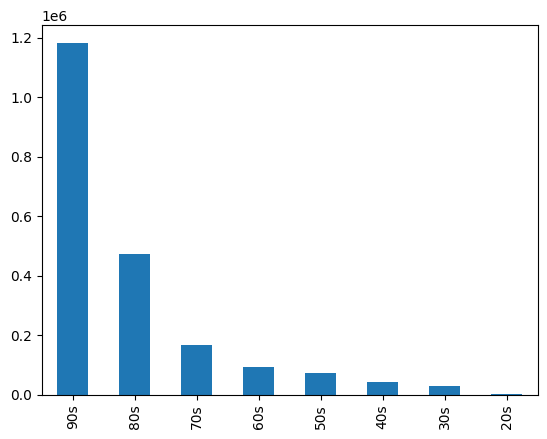

In [58]:
# relese year bin 
mix_df["release_bins"].value_counts().plot(kind='bar')

Grouping the data to check their relationship

In [59]:
# let's see most rated movie 
mix_df.groupby("title")["rating"].count().sort_values(ascending=False).head(10)

title
Men in Black                          10152
Princess Bride, The                    9272
L.A. Confidential                      9152
E.T. the Extra-Terrestrial             9076
Star Wars: Episode IV - A New Hope     8973
Alien                                  8096
Jurassic Park                          8016
Total Recall                           7984
Saving Private Ryan                    7959
Terminator 2: Judgment Day             7947
Name: rating, dtype: int64

In [60]:
mix_df["year"].unique()

array([1995, 1977, 1993, 1992, 1937, 1991, 1996, 1964, 1939, 1958, 1950,
       1941, 1965, 1982, 1975, 1987, 1962, 1989, 1985, 1959, 1997, 1998,
       1988, 1942, 1947, 1999, 1980, 1983, 1986, 1990, 2000, 1994, 1978,
       1961, 1984, 1972, 1976, 1981, 1973, 1974, 1940, 1952, 1954, 1953,
       1944, 1968, 1957, 1946, 1949, 1951, 1963, 1971, 1979, 1967, 1966,
       1948, 1933, 1970, 1969, 1930, 1955, 1956, 1920, 1925, 1938, 1960,
       1935, 1932, 1931, 1945, 1943, 1934, 1936, 1929, 1926, 1927, 1922,
       1919, 1921, 1923, 1928])

In [61]:
# avg rating ,count  per movie 
mix_df[["title","rating"]].groupby("title").agg(["mean","count"]).head(10)

rating      
                                mean count
title                                     
$1,000,000 Duck             3.027027    74
'Night Mother               3.371429    70
'Til There Was You          2.692308   104
'burbs, The                 2.910891   303
...And Justice for All      3.713568   398
1-900                       2.500000     2
10 Things I Hate About You  3.422857  1400
101 Dalmatians              3.381055  1858
12 Angry Men                4.295455   616
13th Warrior, The           3.158667  2250

## Recommender Systems :

### Collaborative Filtering approach :

It is based on how user interacted with the item aka movie in this business case.
* user-item interaction matrix 

In [62]:
mix_df.head(15)

# un explode the generes 


,movie_id,title,genres,year,user_id,rating,timestamp,gender,age,occupation,zip_code,datetime,release_bins
0,1,Toy Story,animation,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
1,1,Toy Story,children,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
2,1,Toy Story,comedy,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
3,48,Pocahontas,animation,1995,1,5,978824351,F,Under 18,K-12 student,48067,2001-01-06 23:39:11,90s
4,48,Pocahontas,children,1995,1,5,978824351,F,Under 18,K-12 student,48067,2001-01-06 23:39:11,90s
5,48,Pocahontas,musical,1995,1,5,978824351,F,Under 18,K-12 student,48067,2001-01-06 23:39:11,90s
6,48,Pocahontas,romance,1995,1,5,978824351,F,Under 18,K-12 student,48067,2001-01-06 23:39:11,90s
7,150,Apollo 13,drama,1995,1,5,978301777,F,Under 18,K-12 student,48067,2000-12-31 22:29:37,90s
8,260,Star Wars: Episode IV - A New Hope,action,1977,1,4,978300760,F,Under 18,K-12 student,48067,2000-12-31 22:12:40,70s
9,260,Star Wars: Episode IV - A New Hope,adventure,1977,1,4,978300760,F,Under 18,K-12 student,48067,2000-12-31 22:12:40,70s


In [63]:
# pivot table with user id and movie id 
piv = mix_df.pivot_table(index='user_id',columns='title',values='rating',aggfunc='mean')

In [64]:
piv.fillna(0,inplace=True) 
piv.shape

(6040, 3640)

In [65]:
piv.head(3)

title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### item- item based approach with corelation :

In [66]:
# pearson correlation by taking input form the user :

# movie_name = input(" Enter your favourite movie name:  ")


Let's try out with the movie "Liar Liar"

In [67]:
# finding the columns of the movie name
co = piv.corrwith(piv['Liar Liar'])

In [68]:
# data frame for correlation
corr_df = pd.DataFrame(co,columns=['correlation'])
corr_df.sort_values(by='correlation',ascending=False).head(10)

,correlation
Liar Liar,1.000000
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654
Home Alone,0.455967
"Wedding Singer, The",0.429222
Wayne's World,0.424552
"Cable Guy, The",0.420942
Tommy Boy,0.413143
Austin Powers: International Man of Mystery,0.411105


In [69]:
find_index = corr_df.sort_values(by='correlation',ascending=False).head(10).index

In [70]:
# find the genre for find_index movies 

movies[movies['title'].isin(find_index)][["title","genres","year"]]



,title,genres,year
228,Dumb & Dumber,Comedy,1994
329,Tommy Boy,Comedy,1995
340,Ace Ventura: Pet Detective,Comedy,1994
496,Mrs. Doubtfire,Comedy,1993
582,Home Alone,Children's|Comedy,1990
774,"Cable Guy, The",Comedy,1996
1455,Liar Liar,Comedy,1997
1482,Austin Powers: International Man of Mystery,Comedy,1997
1720,"Wedding Singer, The",Comedy|Romance,1998
3184,Wayne's World,Comedy,1992


As we can see if the user enters the movie 'Liar Liar' , we can get the top 10 movies that are similar to it with pearson correlation and also look at the genres.

In [71]:
piv["Liar Liar"].sort_values(ascending=False).head(10)

user_id
1778    5.0
1506    5.0
2198    5.0
4028    5.0
1524    5.0
3834    5.0
3111    5.0
809     5.0
3113    5.0
3716    5.0
Name: Liar Liar, dtype: float64

This Item -Item based approach is done on  movies -movies  based on the ratings given by the user. 

Similarly let's do it with cosine similarity

Cosine -similarity b/w movies :

Similarity Matrix for every movie with every other movie

In [72]:
# cosine similarity 
cos_sim =  cosine_similarity(piv.T) 
cos_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [73]:
# dataframe for cosine similarity 
cos_sim_df = pd.DataFrame(cos_sim, index = piv.columns, columns = piv.columns)
cos_sim_df.head(4)

title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.0,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.0,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.0,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.0,0.033567,0.110525


In [74]:
cos_sim_df["Liar Liar"].sort_values(ascending=False).head(10)

title
Liar Liar                                      1.000000
Mrs. Doubtfire                                 0.557067
Ace Ventura: Pet Detective                     0.516861
Dumb & Dumber                                  0.512585
Home Alone                                     0.511204
Wayne's World                                  0.499368
Wedding Singer, The                            0.497076
Austin Powers: International Man of Mystery    0.489473
There's Something About Mary                   0.483263
League of Their Own, A                         0.482074
Name: Liar Liar, dtype: float64

Cosine -similarity b/w movies :

Similarity Matrix for every movie with every other movie

In [75]:
cos_sim_df["Liar Liar"].sort_values(ascending=False).head(10).to_frame("cosine_Similarity")

,cosine_Similarity
title,
Liar Liar,1.000000
Mrs. Doubtfire,0.557067
Ace Ventura: Pet Detective,0.516861
Dumb & Dumber,0.512585
Home Alone,0.511204
Wayne's World,0.499368
"Wedding Singer, The",0.497076
Austin Powers: International Man of Mystery,0.489473
There's Something About Mary,0.483263


In [76]:
# we can also build a user-user similarity with the same approach 

### Knn- based similarity :

In [77]:
# Now let's use knn to find similar movies
piv.head(3).T

user_id,1,10,100
title,,,
"$1,000,000 Duck",0.0,0.0,0.0
'Night Mother,0.0,0.0,0.0
'Til There Was You,0.0,0.0,0.0
"'burbs, The",0.0,4.0,0.0
...And Justice for All,0.0,0.0,0.0
...,...,...,...
"Zed & Two Noughts, A",0.0,0.0,0.0
Zero Effect,0.0,0.0,0.0
Zero Kelvin (Kjærlighetens kjøtere),0.0,0.0,0.0


In [78]:
model = NearestNeighbors(metric = 'cosine',n_neighbors=10,n_jobs=-1)
model.fit(piv.T)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=10)

Passing "lair lair" as input

In [79]:
distance , indices = model.kneighbors(piv.T.loc["Liar Liar"].values.reshape(1,-1),n_neighbors=10)

Remember lesser the distance more similar to the query movie :

In [80]:
# dataframe of similar movies with distance 


knn_based_similarity = pd.DataFrame(index= piv.columns[indices[0]], data = distance[0], columns=["knn_disatnce"])
knn_based_similarity

,knn_disatnce
title,
Liar Liar,0.000000
Mrs. Doubtfire,0.442933
Ace Ventura: Pet Detective,0.483139
Dumb & Dumber,0.487415
Home Alone,0.488796
Wayne's World,0.500632
"Wedding Singer, The",0.502924
Austin Powers: International Man of Mystery,0.510527
There's Something About Mary,0.516737


Matrix Factorisation Approach :

It reduces the dimensionality of the data by decomposing the data into two matrices.

In [85]:
mix_df.head(4)

,movie_id,title,genres,year,user_id,rating,timestamp,gender,age,occupation,zip_code,datetime,release_bins
0,1,Toy Story,animation,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
1,1,Toy Story,children,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
2,1,Toy Story,comedy,1995,1,5,978824268,F,Under 18,K-12 student,48067,2001-01-06 23:37:48,90s
3,48,Pocahontas,animation,1995,1,5,978824351,F,Under 18,K-12 student,48067,2001-01-06 23:39:11,90s


cmfrec requires user_id , movieid , rating

In [87]:
user_item = mix_df[["user_id","movie_id","rating"]] 
user_item.columns = ['UserId','ItemId','Rating'] 
user_item.head(3)

,UserId,ItemId,Rating
0,1,1,5
1,1,1,5
2,1,1,5


In [89]:
print(user_item["UserId"].nunique() , user_item["ItemId"].nunique())

6040 3682


not able to install cmfrec in local machine , works fine in collab

In [ ]:
from cmfrec import CMF


In [ ]:
model_cmf = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False) 
model_cmf.fit(user_item) 

In [ ]:
model.A_.shape, model.B_.shape
#model.A_ gives the embeddings of Users and model.B_ gives the embeddings of Items.

((6040, 4), (3682, 4))

In [ ]:
# The idea is to center the predicted ratings around the global mean, so that the model is not biased towards over- or under-predicting ratings. By adding the global mean, the model can focus on capturing the relative differences between users and items, rather than trying to predict the absolute ratings.

print(model.user_itm.Rating.mean(), model.glob_mean_)  # Average rating and Global Mean


In [ ]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_ 
#Calculating the predicted ratings

rmse = mean_squared_error(rm.values[rm > 0], rm__[rm > 0], squared=False) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse)) 

mape =  mean_absolute_percentage_error(rm.values[rm > 0], rm__[rm > 0]) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

In [ ]:
# embeddings for user_similarity 

user=cosine_similarity(model.A_)

user_sim_matrix = pd.DataFrame(user, index=piv.index, columns=piv.index)
print(user_sim_matrix.head())  #User similarity matrix using the embeddings from matrix factorization

itm=cosine_similarity(model.B_)

itm_sim_matrix = pd.DataFrame(itm, index=user_itm['ItemId'].unique(), columns=user_itm['ItemId'].unique())
itm_sim_matrix.head()  #Item similarity matrix using the embeddings from matrix factorization


In [ ]:
# From piv take the index of movie 'Liar Liar' then we can find co-relation with the itm_sim_matrix 
# just like we did in co-relation similarity above and add cmrec result to the below table.

#### comparing the results of  pearson correlation with cosine similarity 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>correlation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Liar Liar</th>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>Mrs. Doubtfire</th>
      <td>0.499927</td>
    </tr>
    <tr>
      <th>Dumb &amp; Dumber</th>
      <td>0.459601</td>
    </tr>
    <tr>
      <th>Ace Ventura: Pet Detective</th>
      <td>0.458654</td>
    </tr>
    <tr>
      <th>Home Alone</th>
      <td>0.455967</td>
    </tr>
    <tr>
      <th>Wedding Singer, The</th>
      <td>0.429222</td>
    </tr>
    <tr>
      <th>Wayne's World</th>
      <td>0.424552</td>
    </tr>
    <tr>
      <th>Cable Guy, The</th>
      <td>0.420942</td>
    </tr>
    <tr>
      <th>Tommy Boy</th>
      <td>0.413143</td>
    </tr>
    <tr>
      <th>Austin Powers: International Man of Mystery</th>
      <td>0.411105</td>
    </tr>
  </tbody>
</table>
</div>

############################################################################### 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>cosine_Similarity</th>
    </tr>
    <tr>
      <th>title</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Liar Liar</th>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>Mrs. Doubtfire</th>
      <td>0.557067</td>
    </tr>
    <tr>
      <th>Ace Ventura: Pet Detective</th>
      <td>0.516861</td>
    </tr>
    <tr>
      <th>Dumb &amp; Dumber</th>
      <td>0.512585</td>
    </tr>
    <tr>
      <th>Home Alone</th>
      <td>0.511204</td>
    </tr>
    <tr>
      <th>Wayne's World</th>
      <td>0.499368</td>
    </tr>
    <tr>
      <th>Wedding Singer, The</th>
      <td>0.497076</td>
    </tr>
    <tr>
      <th>Austin Powers: International Man of Mystery</th>
      <td>0.489473</td>
    </tr>
    <tr>
      <th>There's Something About Mary</th>
      <td>0.483263</td>
    </tr>
    <tr>
      <th>League of Their Own, A</th>
      <td>0.482074</td>
    </tr>
  </tbody>
</table>
</div>

################################################################# 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>knn_disatnce</th>
    </tr>
    <tr>
      <th>title</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Liar Liar</th>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>Mrs. Doubtfire</th>
      <td>0.442933</td>
    </tr>
    <tr>
      <th>Ace Ventura: Pet Detective</th>
      <td>0.483139</td>
    </tr>
    <tr>
      <th>Dumb &amp; Dumber</th>
      <td>0.487415</td>
    </tr>
    <tr>
      <th>Home Alone</th>
      <td>0.488796</td>
    </tr>
    <tr>
      <th>Wayne's World</th>
      <td>0.500632</td>
    </tr>
    <tr>
      <th>Wedding Singer, The</th>
      <td>0.502924</td>
    </tr>
    <tr>
      <th>Austin Powers: International Man of Mystery</th>
      <td>0.510527</td>
    </tr>
    <tr>
      <th>There's Something About Mary</th>
      <td>0.516737</td>
    </tr>
    <tr>
      <th>League of Their Own, A</th>
      <td>0.517926</td>
    </tr>
  </tbody>
</table>
</div>

-- By Mahikshith